In [19]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


#metrics
from sklearn.metrics import mean_squared_error

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVC

# custom functions
import functions

# Market Data Gathering

In [2]:
# Important dates
start = dt.datetime(2017,8,6)
end = dt.datetime(2022,8,6)


In [3]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

In [4]:
# concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', gspc, 'gspc_')

In [5]:
# remove test data from train
train, test = functions.testSplit(features)

# Feature Engineering

In [6]:
# Establish variables and target
nflx_target = 'nflx_Adj Close'
gspc_target = 'gspc_Adj Close'

# Remove target variable
x_train = functions.dropTarget(train, nflx_target)
x_test = functions.dropTarget(test, nflx_target)
y_train = train[nflx_target]
y_test = test[nflx_target]

In [7]:
# function transformers aren't working for pandas timeshift, storing them here for now.
# # function transform nflx engineering functions
# t_shiftTime = FunctionTransformer(functions.shiftTime)
# t_rollingMeanShift = FunctionTransformer(functions.rollingMeanShift(train))
# t_trendDiff = FunctionTransformer(functions.trendDiff(train))

# # drop target variable
# t_dropTarget = FunctionTransformer(functions.dropTarget)


In [8]:
# feature_engineering = Pipeline([
#     ('t_nflx_shiftTime', functions.shiftTime),
#     # ('t_nflx_rollingMeanShift', t_rollingMeanShift),
#     # ('t_nflx_trendDiff', t_trendDiff)
#     ])

In [9]:
# shift all values by one time step
# train = functions.shiftTime(train, 3).dropna()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2017-08-07 to 2021-08-06
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nflx_High       1008 non-null   float64
 1   nflx_Low        1008 non-null   float64
 2   nflx_Open       1008 non-null   float64
 3   nflx_Close      1008 non-null   float64
 4   nflx_Volume     1008 non-null   int64  
 5   nflx_Adj Close  1008 non-null   float64
 6   gspc_High       1008 non-null   float64
 7   gspc_Low        1008 non-null   float64
 8   gspc_Open       1008 non-null   float64
 9   gspc_Close      1008 non-null   float64
 10  gspc_Volume     1008 non-null   int64  
 11  gspc_Adj Close  1008 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 102.4 KB


In [11]:
pipeline = Pipeline([
    # ('feature_engineering', feature_engineering),
    ('t_nflx_shiftTime', functions.shiftTime(rolling=3)),
    ('Imputer', SimpleImputer()),
    ('scaling', MinMaxScaler()),
    ('PCA', PCA(n_components=5)),
    # ('selectKBest', SelectKBest(f_regression,k=3)),
    ('classifier', LinearRegression()),
    ])

In [12]:
functions.shiftTime(x_train)

shiftTime(rolling=             nflx_High    nflx_Low   nflx_Open  nflx_Close  nflx_Volume  \
Date                                                                      
2017-08-07  182.270004  179.100006  181.000000  181.330002      4609800   
2017-08-08  181.910004  177.449997  181.369995  178.360001      6104000   
2017-08-09  175.960007  170.009995  171.429993  175.779999      9670500   
2017-08-10  174.449997  167.600006  174.029999  169.139999      9693100   
2017-08-11  172.580002  169.000000  169.860001  171.399994      50...
2021-08-05  4429.759766  4408.859863  4408.859863  4429.100098   2734220000   
2021-08-06  4440.819824  4429.069824  4429.069824  4436.520020   2839970000   

            gspc_Adj Close  
Date                        
2017-08-07     2480.909912  
2017-08-08     2474.919922  
2017-08-09     2474.020020  
2017-08-10     2438.209961  
2017-08-11     2441.320068  
...                    ...  
2021-08-02     4387.160156  
2021-08-03     4423.149902  
2021-08-04     4402.660156  
2021-08-05     4429.100098  
2021-08-06     4436.520020  

[1008 rows x 11 columns])

In [13]:
model = pipeline.fit(x_train, y_train)

In [14]:
y_pred = model.predict(x_test)

In [15]:
mean_squared_error(y_test, y_pred)

305.05461970492235

<AxesSubplot:>

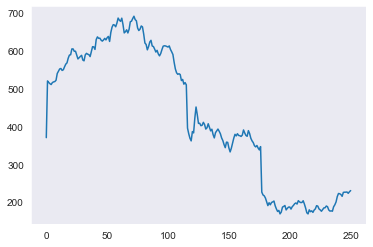

In [16]:
sns.lineplot(data=y_pred)

In [17]:
# model.steps[1][1].get_feature_names_out(x_train.columns)